In [1]:
%matplotlib inline
from cox import readers
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set()

In [2]:
r = readers.CollectionReader('agents')

100%|██████████| 320/320 [00:28<00:00, 11.32it/s]


In [12]:
metadata = r.df('metadata')
opt = r.df('optimization')
opt['opt_step'] = opt.index
#nadv = r.df('normalized_advantage')
#nadv['opt_step'] = (nadv.index % 50) * 10
#constraints = r.df('paper_constraints_train')
#constraints_heldout = r.df('paper_constraints_heldout')

In [6]:
games =  ["Walker2d-v2", "Humanoid-v2", "Swimmer-v2", "Hopper-v2",
          "HalfCheetah-v2", "InvertedPendulum-v2", "Reacher-v2", "InvertedDoublePendulum-v2"]
code_level_opts = {
      #'kl_penalty_coeff': [3, 0.0],
      'kl_penalty_direction': ['new_to_old', 'old_to_new'],
      #'clip_advantages': [1e8],
      #'norm_rewards': ['none', 'returns'],
      #'anneal_lr': [False, True],
      #'value_clipping': [False, True],
      #'initialization': ['xavier', 'orthogonal']
}

NUM_BINS = 20

In [13]:
key_metadata = metadata[['exp_id', 'game'] + list(code_level_opts.keys())]
#constraints = constraints.merge(key_metadata, on='exp_id')
#constraints_heldout = constraints_heldout.merge(key_metadata, on='exp_id')
#nadv = nadv.merge(key_metadata, on='exp_id')
opt = opt.merge(key_metadata, on='exp_id')

# Plot max rewards

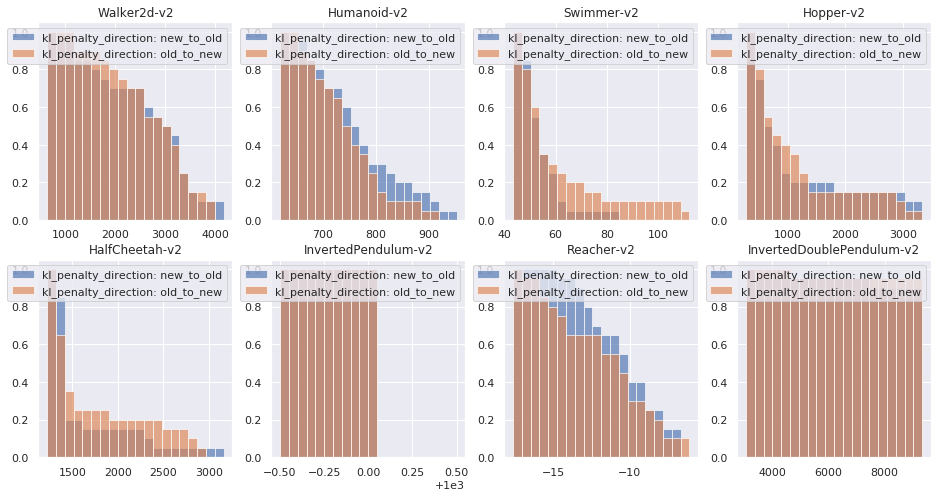

In [8]:
max_rewards = opt.groupby(['exp_id', 'game'] + list(code_level_opts.keys())).max()
max_rewards = max_rewards.reset_index()

# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    # Histogram setup
    _, bin_edges = np.histogram(max_rewards[max_rewards.game == g][
        'mean_reward'].tolist(), NUM_BINS)
    bin_locs = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_ws = (bin_edges[1] - bin_edges[0])
    kwargs = {'width': bin_ws, 'alpha': 0.65}
    
    for i, cl_opt in enumerate(code_level_opts):
        for b in code_level_opts[cl_opt]:
            filt = max_rewards[(max_rewards[cl_opt] == b) & (max_rewards.game == g)]
            hist, _ = np.histogram(filt['mean_reward'].tolist(), bin_edges)
            hist = np.flip(np.cumsum(np.flip(hist))) / np.sum(hist)
            ax.flatten()[j].bar(bin_locs, hist, label=f"{cl_opt}: {b}", **kwargs)
        ax.flatten()[j].legend()
        ax.flatten()[j].set_title(g)
plt.show()

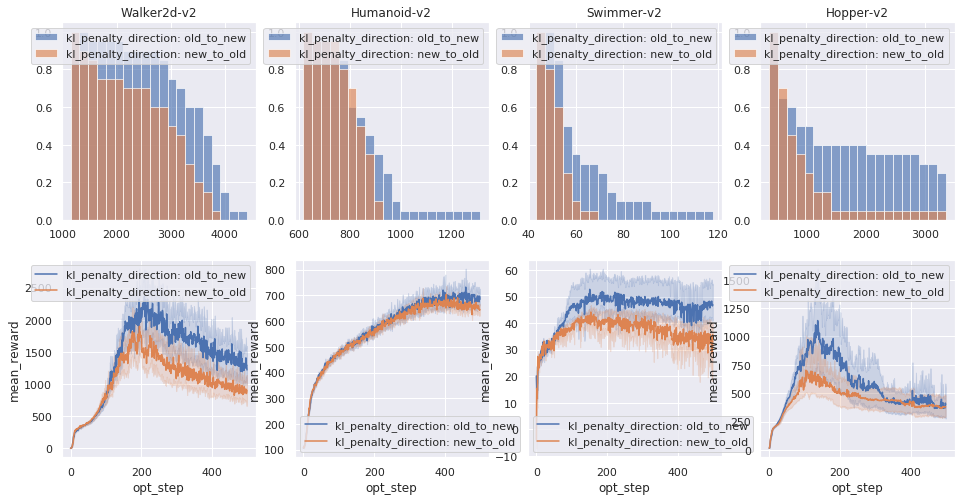

In [55]:
max_rewards = opt.groupby('exp_id').max()

# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    exp_ids_game = set(metadata[(metadata.game == g) & (metadata.kl_penalty_coeff > 0)]['exp_id'].tolist())
    max_rewards_game = max_rewards[max_rewards.index.isin(exp_ids_game)]
    opt_game = opt[opt.index.get_level_values(0).isin(exp_ids_game)]
    
    # Histogram setup
    _, bin_edges = np.histogram(max_rewards[max_rewards.index.isin(exp_ids_game)][
        'mean_reward'].tolist(), NUM_BINS)
    bin_locs = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_ws = (bin_edges[1] - bin_edges[0])
    kwargs = {'width': bin_ws, 'alpha': 0.65}
    
    for cl_opt in ['kl_penalty_direction']:
        for b in reversed(code_level_opts[cl_opt]):
            exp_ids = set(metadata[(metadata[cl_opt] == b)]['exp_id'].tolist())
            filt = max_rewards_game[max_rewards_game.index.isin(exp_ids)]
            hist, _ = np.histogram(filt['mean_reward'].tolist(), bin_edges)
            hist = np.flip(np.cumsum(np.flip(hist))) / np.sum(hist)
            ax[0][j].bar(bin_locs, hist, label=f"{cl_opt}: {b}", **kwargs)
            
            filt = opt_game[opt_game.index.get_level_values(0).isin(exp_ids)]
            sns.lineplot(filt.index.get_level_values(1), filt.mean_reward,
                         ax=ax[1][j], label=f"{cl_opt}: {b}")
        ax[0][j].legend()
        ax[0][j].set_title(g)
plt.show()

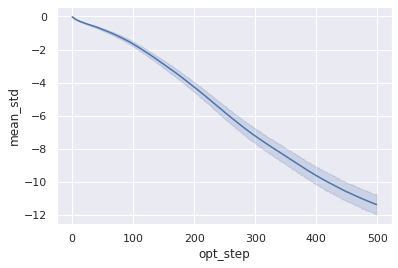

In [9]:
sns.lineplot(x=opt['opt_step'], y=np.log(opt['mean_std']))
plt.show()

# Aggregate performance (max over learning rates, avg over trials)

In [15]:
ks = ['game'] + list(code_level_opts.keys())
grouped_1 = max_rewards.groupby(ks).mean().reset_index().set_index(ks)
grouped_1

mean_reward  final_value_loss  \
game                      kl_penalty_direction                                  
HalfCheetah-v2            new_to_old            1546.779779          0.598566   
                          old_to_new            1636.555080          0.593258   
Hopper-v2                 new_to_old            1018.906731          0.495346   
                          old_to_new            1015.763016          0.546704   
Humanoid-v2               new_to_old             765.580734          1.881527   
                          old_to_new             744.136409          1.991521   
InvertedDoublePendulum-v2 new_to_old            8911.207237        249.459059   
                          old_to_new            9075.596733        242.847424   
InvertedPendulum-v2       new_to_old            1000.000000        632.819347   
                          old_to_new            1000.000000        601.112206   
Reacher-v2                new_to_old             -10.580475          0.582089   
                          old_to_new             -11.642431          0.582139   
Swimmer-v2                new_to_old              53.413694          0.634119   
                          old_to_new              58.706358          0.631486   
Walker2d-v2               new_to_old            2626.559452          0.345538   
                          old_to_new            2703.332188          0.333316   

                                                mean_std  opt_step  
game                      kl_penalty_direction                      
HalfCheetah-v2            new_to_old            0.991528       499  
                          old_to_new            0.992093       499  
Hopper-v2                 new_to_old            0.988833       499  
                          old_to_new            0.986230       499  
Humanoid-v2               new_to_old            0.997917       499  
                          old_to_new            0.998142       499  
InvertedDoublePendulum-v2 new_to_old            0.968355       499  
                          old_to_new            0.975716       499  
InvertedPendulum-v2       new_to_old            0.969052       499  
                          old_to_new            0.974179       499  
Reacher-v2                new_to_old            0.962136       499  
                          old_to_new            0.960228       499  
Swimmer-v2                new_to_old            0.994631       499  
                          old_to_new            0.994900       499  
Walker2d-v2               new_to_old            0.994741       499  
                          old_to_new            0.995503       499